## ROC or Precision/Recall   
While dealing with imbalanced data, should we use ROC or Precision/Recall curve as our tool to find the parameters?

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_curve

import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from IPython.display import display


In [2]:
df = pd.read_csv('./input/creditcard.csv')
display(df.head(3))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


**Note: ** The Time column is recorded in seconds, accumulating from the first record in file. One could transfer elapsing time into the time in a day.

In [3]:
df['hour'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
display(df.head(3))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0


**Note:**  
- Class 0: Legit
- Class 1: Fraud

In [4]:
df.pivot_table(values='Amount', index='hour', columns='Class', aggfunc='count')

Class,0,1
hour,,
0.0,10919,21
1.0,7687,6
2.0,4212,10
3.0,3269,57
4.0,3476,17
5.0,2185,23
6.0,2979,11
7.0,4093,9
8.0,7219,23


In [5]:

def PlotHistogram(df, norm):
    
    bins = np.arange(df['hour'].min(), df['hour'].max()+2)
    plt.figure(figsize=(16, 8))
    sns.distplot(df[df['Class'] == 0]['hour'],
                 norm_hist = norm,
                 bins = bins,
                 kde = False,
                 color = 'b',
                 hist_kws = {'alpha':0.5},
                 label = 'Legit')
    sns.distplot(df[df['Class'] == 1.0]['hour'],
                 norm_hist = norm,
                 bins = bins,
                 kde = False,
                 color = 'r',
                 hist_kws = {'alpha':0.5},
                 label = 'Fraud')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.show()


Normalized Legit/Fraud over hour in a day


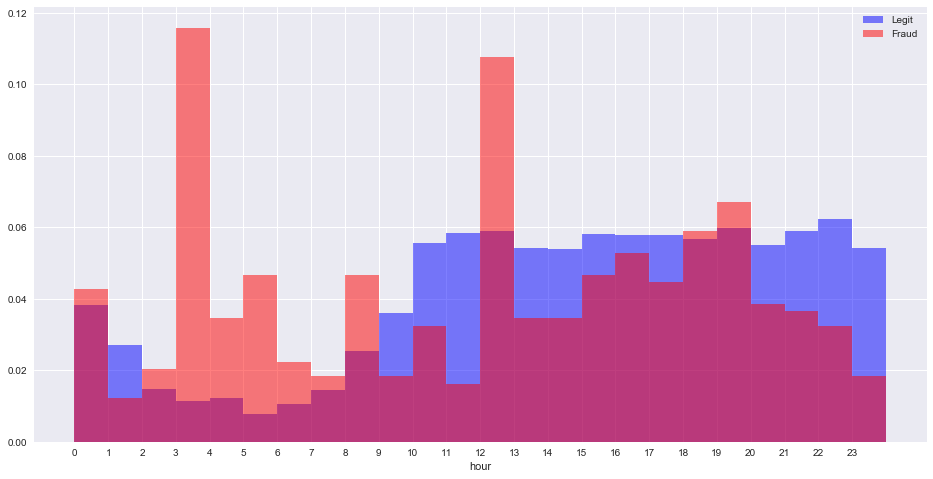

Counts of Legit/Fraud over hour in a day 


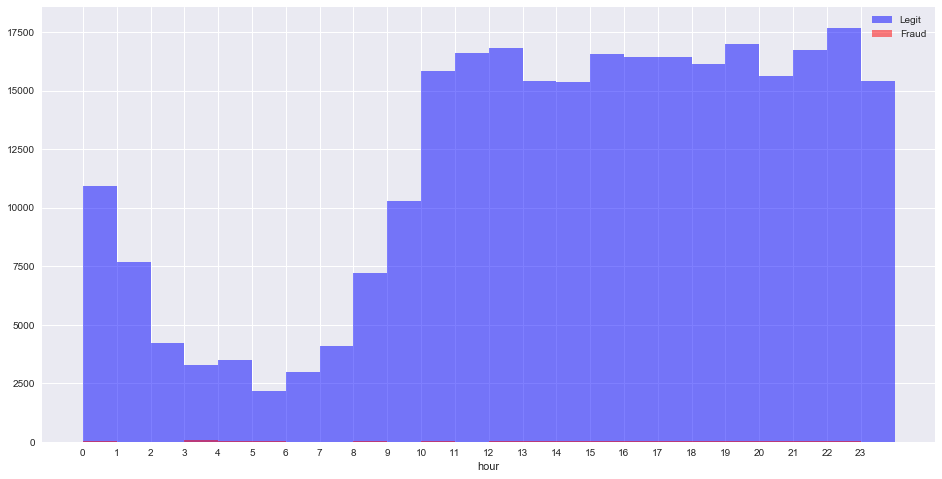

Time elapsed: 2.2830 seconds.


In [6]:

start = time.time()
print('Normalized Legit/Fraud over hour in a day')
PlotHistogram(df, True)
print('Counts of Legit/Fraud over hour in a day ')
PlotHistogram(df, False)
print('Time elapsed: {:.4f} seconds.'.format(time.time()-start))


In [7]:
print(df['Class'].value_counts())

counts_fraud = df['Class'].value_counts()[1]
counts_tot = len(df['Class'])

print("{:.4f}% of data set is fraudulent transaction.".format(counts_fraud/counts_tot * 100))

0    284315
1       492
Name: Class, dtype: int64
0.1727% of data set is fraudulent transaction.


In [77]:
## Scaling

mask_true = (df['Class'] == 1.0)
mask_false = (df['Class'] == 0.0)

print(mask_true.head(5))
print(mask_false.head(5))

0    False
1    False
2    False
3    False
4    False
Name: Class, dtype: bool
0    True
1    True
2    True
3    True
4    True
Name: Class, dtype: bool


In [78]:
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

In [79]:
display(df['Amount'].describe())

count    2.848070e+05
mean     2.727008e-16
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

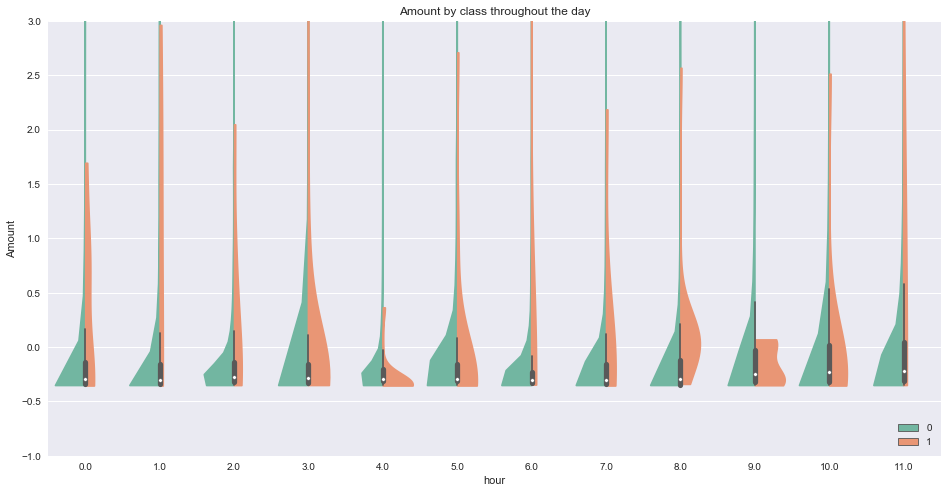

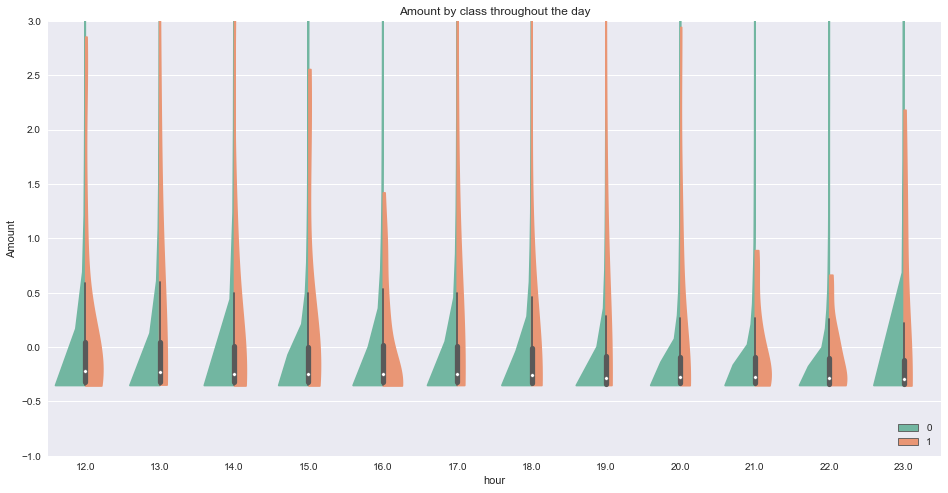

In [80]:
def PlotViolins(minHour, maxHour):
    plt.figure(figsize=[16, 8])
    plt.title('Amount by class throughout the day')
    plt.ylim([-1, 3.0])
    sns.violinplot(data=df[df['hour'].isin(range(minHour, maxHour+1))], 
                   x = 'hour',
                   y = 'Amount',
                   hue = 'Class',
                   split = True,
                   palette = 'Set2',
                   cut = 0)
    plt.legend(loc='lower right')
    plt.show()

PlotViolins(0, 11)
PlotViolins(12, 23)

In [27]:
partial_data = pd.concat([df.loc[::1000, 'V1':'V6'],
                          df.loc[::1000, 'Class']], axis = 1)


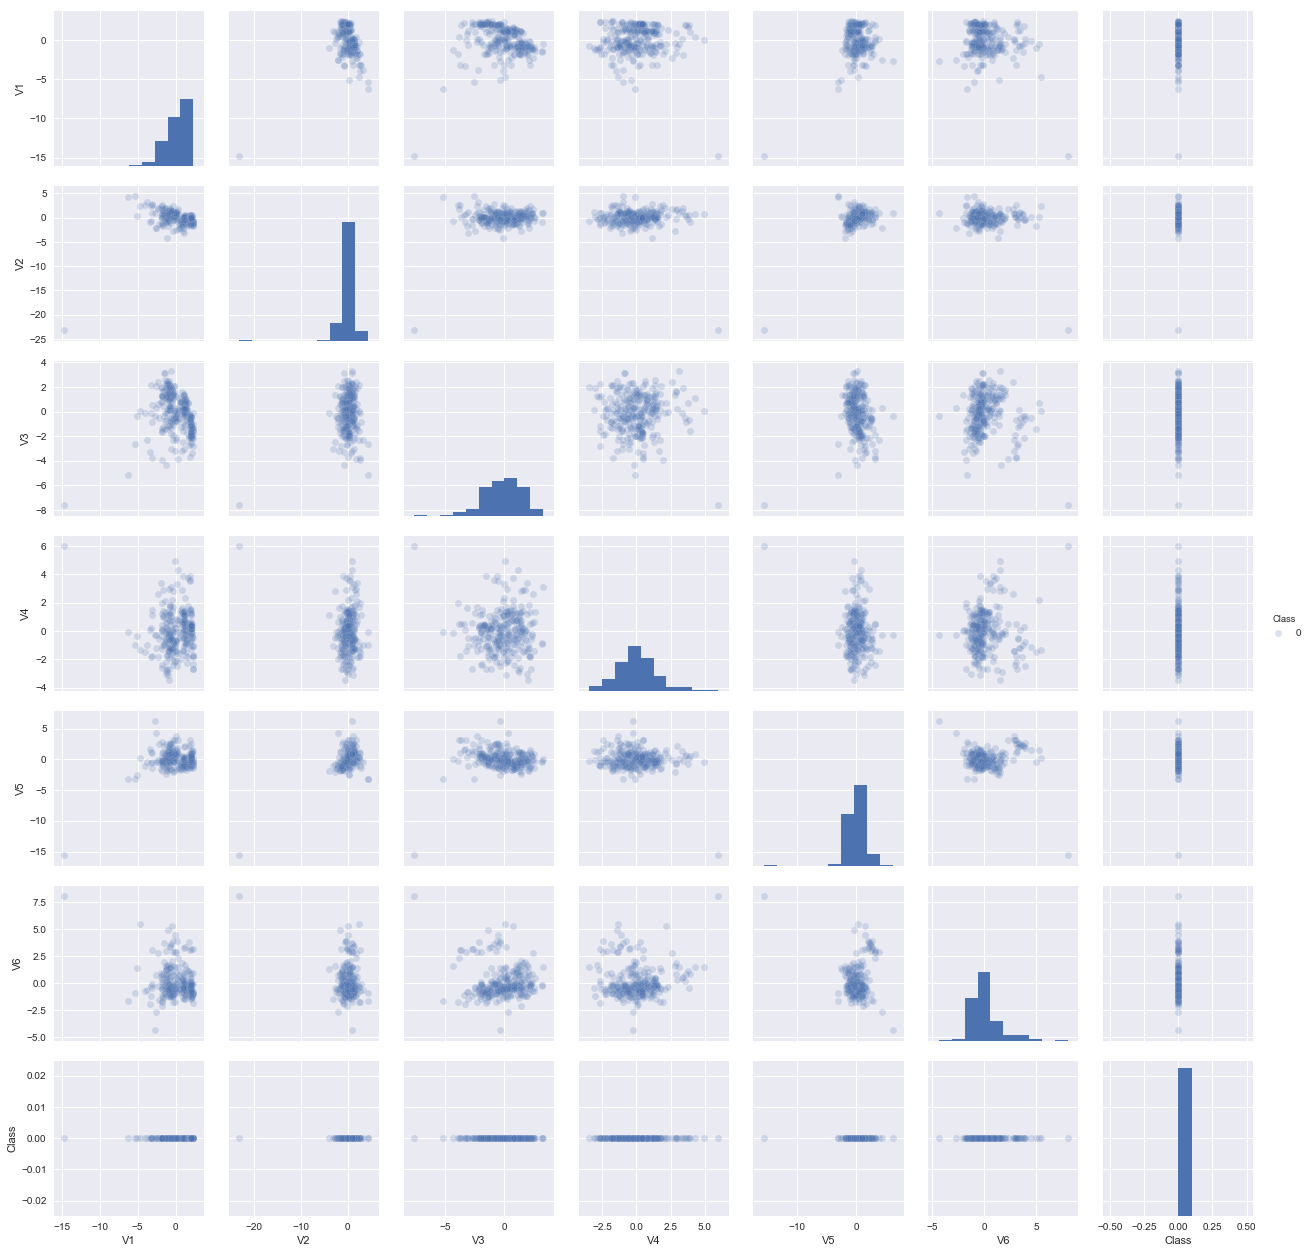

In [31]:
plot = sns.pairplot(partial_data,
             hue='Class',
             plot_kws = {'alpha': 0.2})

In [81]:
##smaller_range = np.random.randint(0, len(df), size=100000)
smaller_range = range(len(df))


features = pd.concat([df.loc[smaller_range, 'V1':'Amount'], 
                      df.loc[smaller_range, 'Time']], axis = 1)

target = df.loc[smaller_range, 'Class']

x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify=target, test_size = 0.1,
                                                    random_state = 123)
print('y_train class counts')
print(y_train.value_counts())
print()
print('y_test class counts')
print(y_test.value_counts())


y_train class counts
0    255883
1       443
Name: Class, dtype: int64

y_test class counts
0    28432
1       49
Name: Class, dtype: int64


In [82]:
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

In [83]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [88]:
def PlotConfusionMatrix(y_test, y_pred, y_test_legit, y_test_fraud):
    cfn_matrix = confusion_matrix(y_test, y_pred)
    cfn_norm_matrix = np.array([ [1.0/y_test_legit, 1.0/y_test_legit],
                                 [1.0/y_test_fraud, 1.0/y_test_fraud] ])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix, cmap='coolwarm_r', linewidth=0.5, annot=True, ax=ax)
    
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.show()
    
    print('---Classfication Report---')
    print(classification_report(y_test, y_pred))

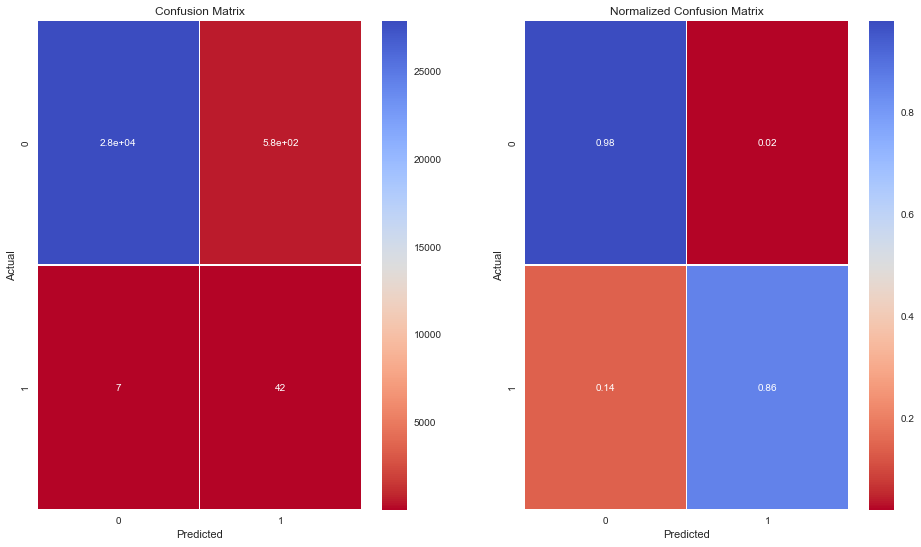

---Classfication Report---
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     28432
          1       0.07      0.86      0.13        49

avg / total       1.00      0.98      0.99     28481



In [89]:
PlotConfusionMatrix(y_test, y_pred, y_test_legit, y_test_fraud)

### Treatment on Imbalanced Data  
Put on some weights on minority class

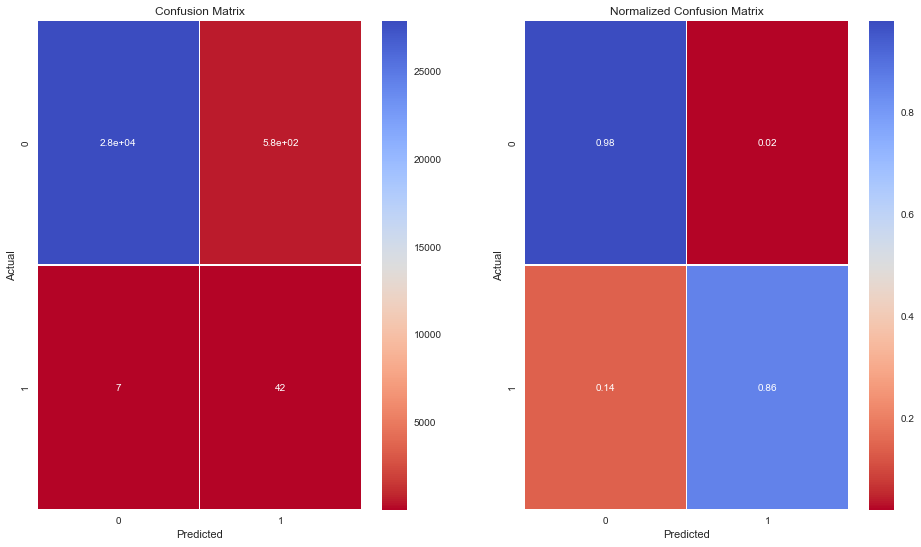

---Classfication Report---
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     28432
          1       0.07      0.86      0.13        49

avg / total       1.00      0.98      0.99     28481



In [90]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
PlotConfusionMatrix(y_test, y_pred, y_test_legit, y_test_fraud)

The weights are somewhat arbitrary but it illustrates the tradeoff between precision and recall.

---Weight of 1 for fraud class---


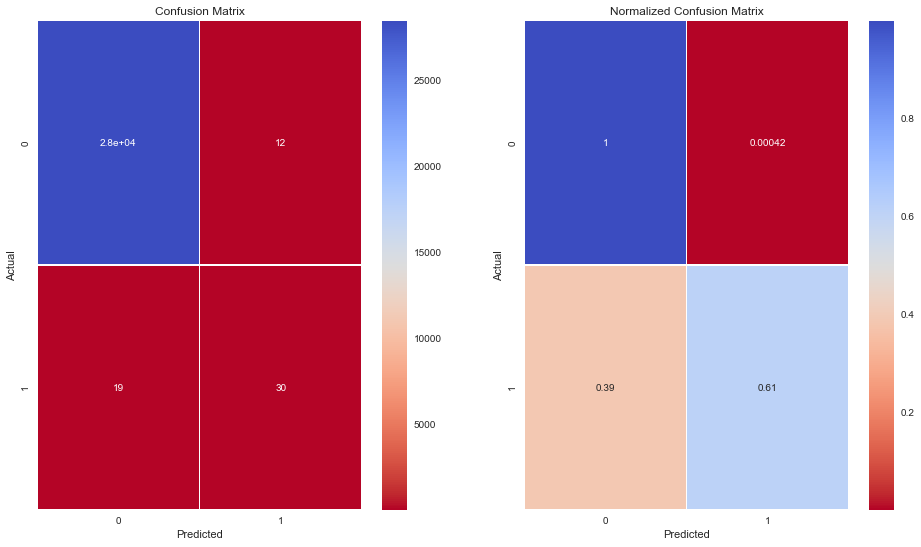

---Classfication Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.71      0.61      0.66        49

avg / total       1.00      1.00      1.00     28481

---Weight of 10 for fraud class---


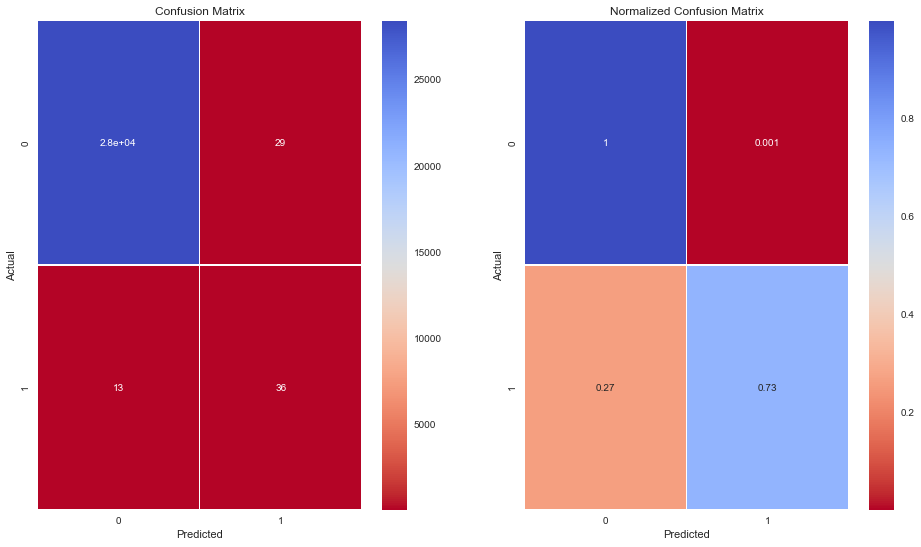

---Classfication Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.55      0.73      0.63        49

avg / total       1.00      1.00      1.00     28481

---Weight of 100 for fraud class---


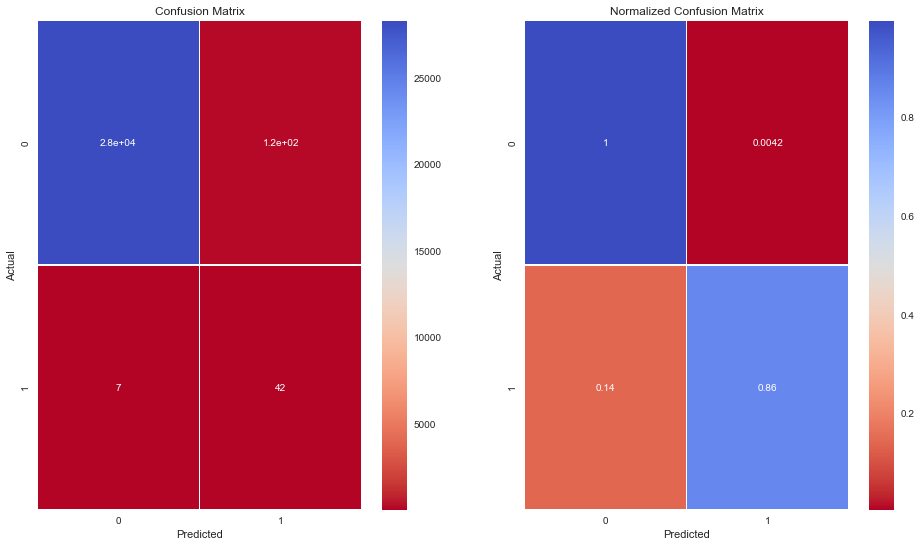

---Classfication Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.26      0.86      0.40        49

avg / total       1.00      1.00      1.00     28481

---Weight of 1000 for fraud class---


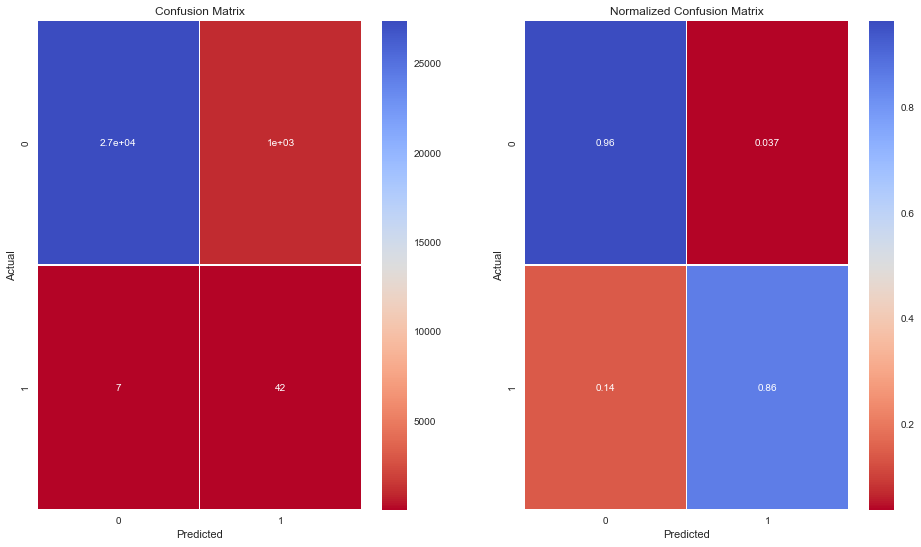

---Classfication Report---
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     28432
          1       0.04      0.86      0.07        49

avg / total       1.00      0.96      0.98     28481



In [94]:
for w in [1, 10, 100, 1000]:
    print('---Weight of {} for fraud class---'.format(w))
    lr = LogisticRegression(class_weight = {0:1, 1:w})
    lr.fit(x_train, y_train)
    
    y_pred = lr.predict(x_test)
    PlotConfusionMatrix(y_test, y_pred, y_test_legit, y_test_fraud)
    

## ROC vs. Precision/Recall Curve  
Demonstration of the tradeoff between precision and recall.

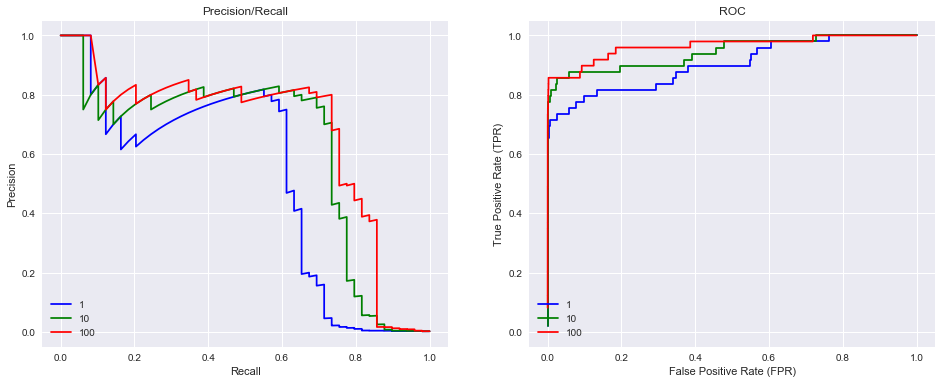

In [98]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision/Recall')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC')

for w, k in zip([1,10,100], 'bgrc'):
    lr = LogisticRegression(class_weight = {0:1, 1:w})
    lr.fit(x_train, y_train)
    y_pred_prob = lr.predict_proba(x_test)[:, 1]
    p, r, _ = precision_recall_curve(y_test, y_pred_prob)
    tpr, fpr, _ = roc_curve(y_test, y_pred_prob)
    
    ax1.plot(r, p, c=k, label= w)
    ax2.plot(tpr, fpr,c=k, label = w)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')

plt.show()




## Reflection  
A good classifier is determined heavily by the upper right corner of the precision/recall curve but by the upper left portion of the ROC. ROC curve is not a good indicator for highly imbalanced data, because the false positive rate (False positives/ total actual negatives) doesn't change dramatically when the total real negatives is huge.

Precision (True Positives/ (True Positives + False Positives)) is affected by the false positives and isn't influenced by a large total actual negatives.

Should we get the high precision with sacrificing the recall? Or are we targeting the high recall? The final decision of picking the right parameters/threshold depends on the business need.